In [77]:
import os
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import corner
from scipy.stats import gaussian_kde

%matplotlib inline

### Tycho-2 Catalog

In [2]:
# Read in sample from Tycho-2 table

filename = ('../data/tycho-2/tyc2.dat')
readme = ('../data/tycho-2/ReadMe')
t = Table.read(filename, format='cds', guess=False, readme=readme)

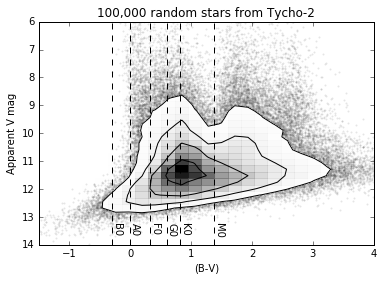

In [3]:
BT = t["BTmag"]
VT = t["VTmag"]
# We can adjust to Johnson magnitudes using conversion from http://www.britastro.org/asteroids/Tycho%20Photometry.htm
V_mag = t["VTmag"] - 0.016 - 0.0741 * (t["BTmag"] - t["VTmag"])
B_mag = t["BTmag"] + 0.064 + 0.2983 * (t["BTmag"] - t["VTmag"])
BV_color = B_mag - V_mag
# From http://stupendous.rit.edu/tass/catalogs/tycho.html (Mamajek, Meyer, & Liebert 2002)
#V_mag = VT + 9.7e-4 - 0.1334*(BT-VT) + 5.486e-2*(BT-VT)**2 - 1.998e-2*(BT-VT)**3
#BV_color = BT-VT - 7.813e-3*(BT-VT) - 1.489e-1*(BT-VT)**2 + 3.384e-2*(BT-VT)**3
#BV_color[np.where(BT-VT < 0.5)] = BT-VT - 0.006 - 1.069e-1*(BT-VT) + 1.459e-1*(BT-VT)**2

#plt.scatter(BV_color, V_mag, marker='.', color='k', alpha=0.05)
corner.hist2d(BV_color, V_mag, bins=50)

plt.xlabel("(B-V)")
plt.ylabel("Apparent V mag")
plt.title("100,000 random stars from Tycho-2")

plt.xlim(-1.5, 4.0)
plt.ylim(14, 6)

# Add lines linking colors to stellar type
# Values from http://www.stsci.edu/~inr/intrins.html (Ducati et al. 2001)
plt.axvline(-0.3, color='k', linestyle='dashed') # B0 star
plt.text(-0.3,13.5,'B0',rotation=-90)
plt.axvline(-0.01, color='k', linestyle='dashed') # A0 star
plt.text(-0.01,13.5,'A0',rotation=-90)
plt.axvline(0.32, color='k', linestyle='dashed') # F0 star
plt.text(0.32,13.5,'F0',rotation=-90)
plt.axvline(0.60, color='k', linestyle='dashed') # G0 star
plt.text(0.6,13.5,'G0',rotation=-90)
plt.axvline(0.81, color='k', linestyle='dashed') # K0 star
plt.text(0.81,13.5,'K0',rotation=-90)
plt.axvline(1.37, color='k', linestyle='dashed') # M0 star
plt.text(1.37,13.5,'M0',rotation=-90)

plt.savefig('../figures/tycho2_colors.pdf')
#plt.show()

### Tycho-2 Double Star Catalog

In [2]:
# Read in Tycho-2 Double Star Catalog table

filename = ('../data/TDSC/catalog.dat')
readme = ('../data/TDSC/ReadMe')
t_TDSC = Table.read(filename, format='ascii.fixed_width_no_header')

In [56]:
# Binary id
ID = t_TDSC['col1']

# Photometry
B_tyc = t_TDSC['col17']
V_tyc = t_TDSC['col19']

# Position
ra = t_TDSC['col5']
ra_err = t_TDSC['col7']
dec = t_TDSC['col6']
dec_err = t_TDSC['col8']

# Proper motion
mu_ra = t_TDSC['col12']
mu_ra_err = t_TDSC['col14']
mu_dec = t_TDSC['col13']
mu_dec_err = t_TDSC['col15']

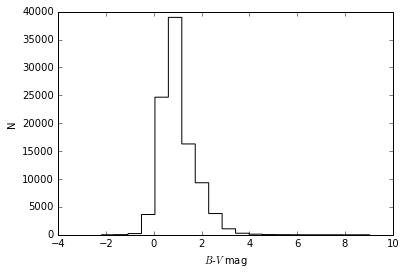

In [16]:
V_mag = V_tyc - 0.016 - 0.0741 * (B_tyc - V_tyc)
B_mag = B_tyc + 0.064 + 0.2983 * (B_tyc - V_tyc)


plt.hist(B_mag - V_mag, histtype='step', color='k', bins=20)
plt.xlabel(r'$B$-$V$ mag')
plt.ylabel('N')

plt.show()

In [80]:
def sep_degree(ra1, dec1, ra2, dec2):
    return np.sqrt((ra1-ra2)**2 * np.cos(dec1)*np.cos(dec2) + (dec1-dec2)**2)

theta = np.array([])

for i in np.arange(len(t_TDSC)):
    if t_TDSC['col2'][i] == "A":
        ra1 = ra[i]
        dec1 = dec[i]
        continue
    
    ra2 = ra[i]
    dec2 = dec[i]
    
    theta = np.append(theta, sep_degree(ra1, dec1, ra2, dec2))
    
# theta is in degrees. Let's change to arcseconds
theta = theta * 3600.0

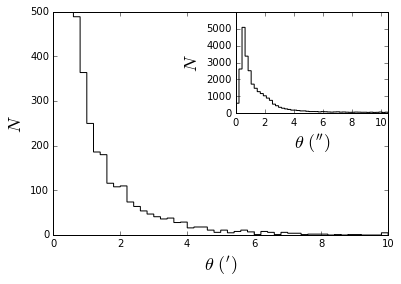

In [104]:
fig = plt.figure()

plt.hist(theta/60.0, histtype='step', range=[0.0, 10.0], color='k', bins=50)
plt.ylim(0.0, 500)
plt.xlim(0.0, 10.0)
plt.xlabel(r'$\theta\ (^{\prime})$', fontsize=18)
plt.ylabel(r'$N$', fontsize=18)

ax1 = fig.add_subplot(222)
ax1.hist(theta, histtype='step', range=[0.0,10.5], color='k', bins=50)
ax1.set_xlim(0.0, 10.5)
ax1.set_xlabel(r'$\theta\ (^{\prime\prime})$', fontsize=18)
ax1.set_ylabel(r'$N$', fontsize=18)
ax1.set_yticks([0, 1000, 2000, 3000, 4000, 5000])

plt.tight_layout()
plt.savefig('../figures/TDSC_separation.pdf')
#plt.show()

## Now, back to the Tycho-2 Catalog

In [4]:
print t.colnames

['TYC1', 'TYC2', 'TYC3', 'pflag', 'RAmdeg', 'DEmdeg', 'pmRA', 'pmDE', 'e_RAmdeg', 'e_DEmdeg', 'e_pmRA', 'e_pmDE', 'EpRAm', 'EpDEm', 'Num', 'q_RAmdeg', 'q_DEmdeg', 'q_pmRA', 'q_pmDE', 'BTmag', 'e_BTmag', 'VTmag', 'e_VTmag', 'prox', 'TYC', 'HIP', 'CCDM', 'RAdeg', 'DEdeg', 'EpRA-1990', 'EpDE-1990', 'e_RAdeg', 'e_DEdeg', 'posflg', 'corr']


### Let's check quality of proper motion data

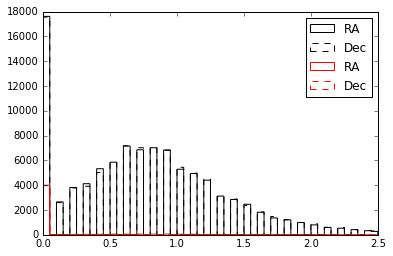

In [40]:
xmin, xmax = 0.0, 2.5

plt.hist(t['q_pmRA'], bins=50, color='k', histtype='step', linestyle='-', label='RA', range=[xmin,xmax])
plt.hist(t['q_pmDE'], bins=50, color='k', histtype='step', linestyle='--', label='Dec', range=[xmin,xmax])

plt.hist(t['q_pmRA'][np.where(t['pmRA']==0.0)], bins=50, color='r', histtype='step', linestyle='-', label='RA', range=[xmin,xmax])
plt.hist(t['q_pmDE'][np.where(t['pmDE']==0.0)], bins=50, color='r', histtype='step', linestyle='--', label='Dec', range=[xmin,xmax])

plt.legend()
plt.show()

### So, we will select only those pairs with proper motion qualities greater than 0.1 for both RA and Dec

We are left with 81227 systems
Just to check:


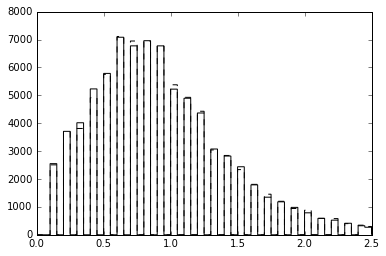

In [49]:
t_tmp = t[np.where(t['q_pmRA'] >= 0.1)]
t_clean = t_tmp[np.where(t_tmp['q_pmDE'] >= 0.1)]

print "We are left with", len(t_clean), "systems"

print "Just to check:"

plt.hist(t_clean['q_pmRA'], bins=50, color='k', histtype='step', linestyle='-', label='RA', range=[xmin,xmax])
plt.hist(t_clean['q_pmDE'], bins=50, color='k', histtype='step', linestyle='--', label='Dec', range=[xmin,xmax])

plt.show()

### Let's also look at the typical proper motion uncertainties

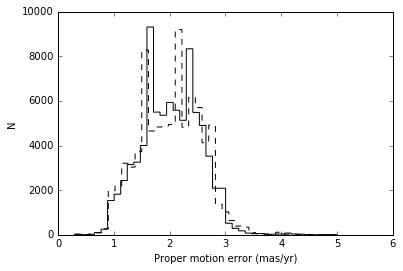

In [60]:
plt.hist(t_clean['e_pmRA'], histtype='step', color='k', linestyle='-', bins=40)
plt.hist(t_clean['e_pmDE'], histtype='step', color='k', linestyle='--', bins=40)

plt.xlabel('Proper motion error (mas/yr)')
plt.ylabel('N')

plt.show()

### Now, let's look at the proper motions

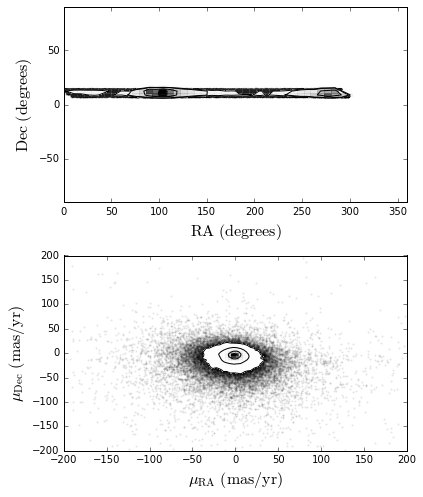

In [61]:
fig, ax = plt.subplots(2,1, figsize=(6,7))

contourf_kwargs = {'bins':50}
corner.hist2d(t_clean['RAmdeg'], t_clean['DEmdeg'], range=[(0,360),(-90,90)], ax=ax[0], **contourf_kwargs)
#plt.scatter(t['ra'], t['dec'], marker='.', alpha=0.1)
ax[0].set_xlim(0,360)
ax[0].set_ylim(-90,90)
ax[0].set_xlabel(r'${\rm RA\ (degrees)}$', size=16)
ax[0].set_ylabel(r'${\rm Dec\ (degrees)}$', size=16)

contourf_kwargs = {'bins':50}
corner.hist2d(t_clean['pmRA'], t_clean['pmDE'], range=[(-100,100),(-100,100)], ax=ax[1], **contourf_kwargs)
ax[1].set_xlabel(r'$\mu_{\rm RA}\ {\rm (mas/yr)}$', size=16)
ax[1].set_ylabel(r'$\mu_{\rm Dec}\ {\rm (mas/yr)}$', size=16)
ax[1].set_xlim(-200,200)
ax[1].set_ylim(-200,200)

plt.tight_layout()
plt.show()

### Now, a bunch of functions to calculate the random alignment probability

In [73]:
mu_kde = None
binary_kde = None

In [115]:
def deg_to_rad(theta):
    """ Convert from degrees to radians """
    return np.pi * theta / 180.0

def rad_to_deg(theta):
    """ Convert from radians to degrees """
    return 180.0 * theta / np.pi

def get_theta_proj_degree(ra, dec, ra_b, dec_b):
    """ Return angular distance between two points

    Parameters
    ----------
    ra : float64
        Right ascension of first coordinate (degrees)
    dec : float64
        Declination of first coordinate (degrees)
    ra_b : float64
        Right ascension of second coordinate (degrees)
    dec_b : float64
        Declination of second coordinate (degrees)

    Returns
    -------
    theta : float64
        Angular distance (degrees)
    """

    ra1 = deg_to_rad(ra)
    dec1 = deg_to_rad(dec)
    ra2 = deg_to_rad(ra_b)
    dec2 = deg_to_rad(dec_b)

    dist = np.sqrt((ra1-ra2)**2 * np.cos(dec1)*np.cos(dec2) + (dec1-dec2)**2)

    return rad_to_deg(dist)


def get_delta_mu(mu_ra, mu_dec, mu_ra_b, mu_dec_b):
    """ Return proper motion difference between two points

    Parameters
    ----------
    mu_ra : float64
        Proper motion in RA of first object (mas/yr)
    mu_dec : float64
        Proper motion in Dec of first object (mas/yr)
    mu_ra_b : float64
        Proper motion in RA of second object (mas/yr)
    mu_dec_b : float64
        Proper motion in Dec of second object (mas/yr)

    Returns
    -------
    delta_mu : float64
        proper motion difference (mas/yr)
    """

    delta_mu = np.sqrt((mu_ra-mu_ra_b)**2 + (mu_dec-mu_dec_b)**2)

    return delta_mu




def nstars_nearby(ra, dec, radius=1.0, catalog=None):
    """ This function searches the catalog for all stars
    within some input radius.
        
    Arguments
    ---------
    ra, dec : float
        Search coordinate (degrees)
    radius : float
        Search radius (degrees)
    catalog : structure
        Catalog to search through
        
    Returns
    -------
    nstars : float
        Number of stars within given radius around input
        coordinate
    """
    
    if catalog is None: 
        print "You must supply an input catalog"
        return
    
    
    ra_rad1 = deg_to_rad(ra)
    dec_rad1 = deg_to_rad(dec)
    ra_rad2 = deg_to_rad(catalog['RAmdeg'])
    dec_rad2 = deg_to_rad(catalog['DEmdeg'])
    
    dist = rad_to_deg(np.sqrt((ra_rad1-ra_rad2)**2 * np.cos(dec_rad1)*np.cos(dec_rad2) + (dec_rad1-dec_rad2)**2))

    return len(np.where(dist<radius)[0])


def get_local_density(ra, dec, catalog=None):
    """ This function calculates the local stellar density
    
    Parameters
    ----------
    ra, dec : float
        Coordinates to find the local stellar density
    catalog : structure
        Catalog to search through
        
    Returns
    -------
    rho_star : float
        Local density of stars per square degree
    """
    
    # Estimate number density of stars from number of systems within 5 degrees
    rad = 5.0
    rho_star = (nstars_nearby(ra, dec, radius=rad, catalog=catalog)-1) / (4.0*np.pi* rad**2)

    return rho_star
    

def get_random_alignment_P_pos(ra1, dec1, ra2, dec2, density=None, catalog=None):
    """ This function determines the probability of two 
    positions to be formed from simple random draws.
    Still need to check math
    
    Arguments
    ---------
    ra1, dec1 : float
        The first star's coordinates
    ra2, dec2 : float
        The second star's coordinates
    
    Returns
    -------
    P(pos) : float
        The probability, due to random alignments of randomly
        forming two stars with the given positions
    """


    # Catalog check
    if catalog is None: 
        print "You must provide a catalog"
        return
    
    # Projected distance
    theta = get_theta_proj_degree(ra1, dec1, ra2, dec2)
    
    # Local stellar density, if not provided
    if density is None:
        density = get_local_density(ra1, dec1, catalog=catalog)
    
    # P(pos)
    P_pos = 2.0*np.pi*theta * density
    
    return P_pos
    

In [111]:


def get_P_mu(mu_ra, mu_dec, catalog=None, method='kde'):
    """ This function calculates the probability of a 
    random star having the observed proper motion
    
    Parameters
    ----------
    mu_ra, mu_dec : float
        Proper Motion likelihood to calculate
    catalog : structure
        Catalog to search through
    method : string
        Method to perform 2D interpolation (options:kde)
        
    Returns
    -------
    P(mu) : float
        Probability of the proper motion
    """

    # Catalog check
    if catalog is None: 
        print "You must include a catalog."
        return

    if method is 'kde':
        # Use a Gaussian KDE
        global mu_kde
        if mu_kde is None: mu_kde = gaussian_kde((catalog["pmRA"], catalog["pmDE"]))
        P_mu = mu_kde.evaluate((mu_ra, mu_dec))
    elif method is 'empirical':
        r = 5.0
        n_stars_near = nstars_nearby_mu(mu_ra, mu_dec, radius=r, catalog=t_clean)-1
        P_mu = n_stars_near / (4.0*np.pi*r**2)
    else: 
        print "You must input an appropriate method."
        print "Options: 'kde' only"
        return
        
    return P_mu



def nstars_nearby_mu(mu_ra, mu_dec, radius=1.0, catalog=None):
    """ This function searches the catalog for all stars
    within some input proper motion radius.
        
    Arguments
    ---------
    mu_ra, mu_dec : float
        Search coordinate (mas/yr)
    radius : float
        Search radius (mas/yr)
    catalog : structure
        Catalog to search through
        
    Returns
    -------
    nstars : float
        Number of stars within given proper motion radius around input
        coordinate
    """
    
    if catalog is None: 
        print "You must supply an input catalog"
        return
    
    dist = np.sqrt((mu_ra-catalog['pmRA'])**2 + (mu_dec-catalog['pmDE'])**2)

    return len(np.where(dist<radius)[0])




def get_random_alignment_P_mu(mu_ra1, mu_dec1, mu_ra2, mu_dec2, density=None, catalog=None):
    """ Unperfected!!!
    This function determines the probability of two proper
    motions to be formed from simple random draws
    
    Arguments
    ---------
    mu_ra1, mu_dec1 : float
        The first star's proper motion
    mu_ra2, mu_dec2 : float
        The second star's proper motion
    
    Returns
    -------
    P(mu) : float
        The probability, due to random alignments of randomly
        forming two stars with the given proper motion
    """
    
    # Catalog check
    if catalog is None: 
        print "You must include a catalog."
        return

    
    # Proper motion difference in degrees/yr
    delta_mu = np.sqrt((mu_ra1-mu_ra2)**2 + (mu_dec1-mu_dec2)**2)
    # delta_mu = get_theta_proj_degree(mu_ra1, mu_dec1, mu_ra2, mu_dec2)
    
    mu_ra_avg = (mu_ra1 + mu_ra2)/2.0
    mu_dec_avg = (mu_dec1 + mu_dec2)/2.0
    
    # density = get_P_mu(mu_ra2, mu_dec2, catalog=t, method='kde')
    if density is None:
        # density = get_P_mu(mu_ra1, mu_dec1, catalog=catalog, method='kde')
        density = get_P_mu(mu_ra1, mu_dec1, catalog=catalog, method='empirical')
    
    P_mu = 2.0*np.pi*delta_mu * density

    return P_mu

In [112]:
def get_P_random_alignment(ra1, dec1, ra2, dec2, mu_ra1, mu_dec1, mu_ra2, mu_dec2, 
                           pos_density=None, pm_density=None, catalog=None):
    """ This function calculates the probability of a 
    pair of stars being formed due to random alignments.
    
    Parameters
    ----------
    ra1, dec1 : float
        Coordinates of the first star
    ra2, dec2 : float
        Coordinates of the second star
    mu_ra1, mu_dec1 : float
        Proper motion of the first star
    mu_ra2, mu_dec2 : float
        Proper motion of the second star
    catalog : structure
        Catalog to search through
        
    Returns
    -------
    P(data) : float
        Probability that the pair was produced randomly
    """

    # Catalog check
    if catalog is None:
        print "Must provide a catalog"
        return
    
    # P(pos)
    if pos_density is None:
        P_pos = get_random_alignment_P_pos(ra1, dec1, ra2, dec2, catalog=catalog)
    else: 
        P_pos = get_random_alignment_P_pos(ra1, dec1, ra2, dec2, 
                                           density=pos_density, catalog=catalog)
        
    # P(mu)
    if pm_density is None:
        P_mu = get_random_alignment_P_mu(mu_ra1, mu_dec1, mu_ra2, mu_dec2, catalog=catalog)
    else:
        P_mu = get_random_alignment_P_mu(mu_ra1, mu_dec1, mu_ra2, mu_dec2, 
                                         density=pm_density, catalog=catalog)
    
    # So long as probabilities are independent:
    # P(pos,mu) = P(pos) * P(mu)
    P_pos_mu = P_pos * P_mu
    
    return P_pos_mu
    

### A sample system to check the method

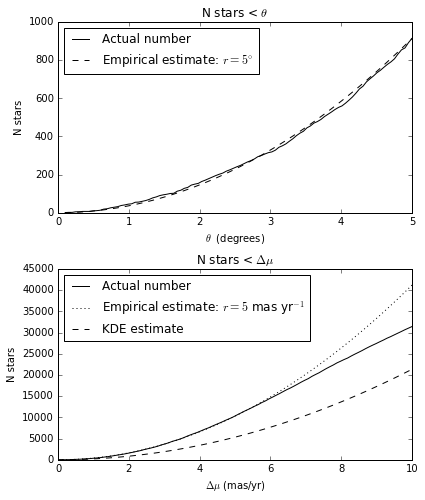

In [96]:
fig, ax = plt.subplots(2,1, figsize=(6,7))

i=3344


# Position panel
ra_in = t_clean['RAmdeg'][i]
dec_in = t_clean['DEmdeg'][i] 
#print ra_in, dec_in

radius = np.linspace(0.1, 5.0, 100)
nstars = np.zeros(100)
for j in np.arange(100):
    r = radius[j]
    nstars[j] = nstars_nearby(ra_in, dec_in, radius=r, catalog=t_clean)-1
ax[0].plot(radius, nstars, color='k', label='Actual number')

# Compare to density estimate derived from a 5 degree radius
r = 5.0
n_stars_near = nstars_nearby(ra_in, dec_in, radius=r, catalog=t_clean)-1
n_density = n_stars_near / (4.0*np.pi*r**2)
y = (4.0*np.pi)*n_density*radius**2
ax[0].plot(radius,y, color='k', linestyle='--', label=r'Empirical estimate: $r=5^{\circ}$')

ax[0].set_title(r'N stars < $\theta$')
ax[0].set_xlabel(r'$\theta\ $ (degrees)')
ax[0].set_ylabel('N stars')
ax[0].legend(loc=2)




# Proper motion panel
mu_ra_in = t_clean['pmRA'][i]
mu_dec_in = t_clean['pmDE'][i] 

pm_density = get_P_mu(mu_ra_in, mu_dec_in, catalog=t_clean, method='kde')
delta_mu = np.linspace(0.0, 10.0, 100)
P_mu = 4.0*np.pi*delta_mu**2*pm_density

N_stars = np.zeros(100)
for i in np.arange(100):
    N_stars[i] = nstars_nearby_mu(mu_ra_in, mu_dec_in, delta_mu[i], catalog=t_clean)

ax[1].plot(delta_mu, N_stars, color='k', label='Actual number')



# Compare to density estimate derived from a 5 mas/yr radius
r = 5.0
n_stars_near = nstars_nearby_mu(mu_ra_in, mu_dec_in, radius=r, catalog=t_clean)-1
n_density = n_stars_near / (4.0*np.pi*r**2)
y = (4.0*np.pi)*n_density*delta_mu**2
ax[1].plot(delta_mu,y, color='k', linestyle='dotted', label=r'Empirical estimate: $r=5$ mas yr$^{-1}$')




norm_factor = mu_kde.factor*len(t_clean['RAmdeg'])
ax[1].plot(delta_mu, P_mu*norm_factor, color='k', linestyle='--', label='KDE estimate')

ax[1].set_xlim(0.0,10.0)

ax[1].set_title(r'N stars < $\Delta \mu$')
ax[1].set_xlabel(r'$\Delta \mu$ (mas/yr)')
ax[1].set_ylabel('N stars')

ax[1].legend(loc=2)


plt.tight_layout()
plt.savefig('../figures/tycho-2_local_density.pdf')
#plt.show()

In [120]:
length = len(t_clean)
#length = 2

print "We are testing", len(t_clean), "stars..."

dtype = [('i_1','i4'),('i_2','i4'),('ID_1','i4'),('ID_2','i4'),('P_random','f8'),('P_binary','f8')]
prob_out = np.zeros(length, dtype=dtype)

for i in np.arange(length):
    
    if i%1000 == 0: print i
    
    star1 = t_clean['RAmdeg'][i], t_clean['DEmdeg'][i], t_clean['pmRA'][i], t_clean['pmDE'][i], t_clean['e_pmRA'][i], t_clean['e_pmDE'][i]

    # Random Alignment
    pos_density = get_local_density(star1[0], star1[1], catalog=t_clean)
    pm_density = get_P_mu(star1[2], star1[3], catalog=t_clean, method='empirical')

    # To Do: Select only potential companion stars within 1 degree as possible pairs

    # Set IDs
    ID_1 = t_clean['TYC1'][i]*100000+t_clean['TYC2'][i]
    
    prob = np.zeros(len(t_clean)-i-1)
    for j in np.arange(len(t_clean)-i-1)+i+1:

        ID_2 = t_clean['TYC1'][j]*100000+t_clean['TYC2'][j]
        if ID_1 == ID_2:
            prob[j-i-1] = 1000.0
            continue
            
        star2 = t_clean['RAmdeg'][j], t_clean['DEmdeg'][j], t_clean['pmRA'][j], t_clean['pmDE'][j], t_clean['e_pmRA'][j], t_clean['e_pmDE'][j]
        
        P_random = get_P_random_alignment(star1[0], star1[1], star2[0], star2[1],
                                          star1[2], star1[3], star2[2], star2[3], 
                                          pos_density=pos_density, pm_density=pm_density,
                                          catalog=t_clean)

        prob[j-i-1] = P_random
        
#     # Binary probability for best matching pair
#     j = np.argmin(prob)+i+1
#     star2 = t_clean['RAmdeg'][j], t_clean['DEmdeg'][j], t_clean['pmRA'][j], t_clean['pmDE'][j], t_clean['e_pmRA'][j], t_clean['e_pmDE'][j]
#     theta = get_theta_proj_degree(star1[0], star1[1], star2[0], star2[1]) * 3600.0
#     delta_mu = np.sqrt((star1[2]-star2[2])**2 + (star1[3]-star2[3])**2)
#     delta_mu_err = np.sqrt(star1[4]**2 + star1[5]**2 + star2[4]**2 + star2[5]**2)
#     if theta > 3600.0:
#         P_binary = 0.0
#     else:
#         delta_mu_sample = normal(loc=delta_mu, scale=delta_mu_err, size=100)
#         P_binary = 1.0/100 * np.sum(get_P_binary(theta, delta_mu_sample, sim_binaries=b))

    
    prob_out['i_1'][i] = i
    prob_out['i_2'][i] = j
    prob_out['ID_1'][i] = ID_1
    prob_out['ID_2'][i] = ID_2
    prob_out['P_random'][i] = prob[j-i-1]
#     prob_out['P_binary'][i] = P_binary
    # print i, np.argmin(prob)+i+1, prob[np.argmin(prob)]
    
print "... finished"

We are testing 81227 stars...
0


KeyboardInterrupt: 

In [124]:
print len(prob_out["ID_1"][np.where(prob_out["ID_1"]>0.0)])

332
